In [16]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from scipy.linalg import LinAlgError, solve

Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_2_list_adapted = None

# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)

hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.366e-29     # Dipole moment between states (|1> and |3>) (C·m)
mu_23 = 1.058e-29     # Dipole moment between states (|2> and |3>) (C·m)
c = 3e8

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 0.5 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 0.5 * Gamma3   # Decay from level 3 to level 2 (MHz)

# in the ideal case, there will be no Gamma12 and Gamma21 since there will be minimum collision 
# therefore there will be minimum population transfer between the two ground states
Gamma12 = Gamma21 = 0    # Decay rates between levels 1 and 2 (MHz)

# Decoherence terms
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
# In this case is the gamma12 also zero?
gamma12 = 1e-5 * Gamma3   # Decoherence rate between ground states (MHz)

w_1 = 2 * np.pi * 3.771120414e14
w_2 = 2 * np.pi * 3.771052067e14
k_1 = w_1 / 3e8
k_2 = w_2 / 3e8
L = 0.02        # Length in meters

OD_0 = 50
N = OD_0 / ((4 * np.pi * mu_13**2 * L) / (Gamma3 * 10**6 * hbar * epsilon_0 * 795e-9))

print("Atomic Density (OD0={:.2f}) = {:.2e}".format(OD_0, N))
w_p = 2 * np.pi * 3e8 / 795e-9
k_0 = w_p / 3e8

Atomic Density (OD0=50.00) = 2.98e+16


### Figure 2c and 2d

For figure 2c, we want to plot the EIT transmission spectrum in order to explore the effects of detuning. The transmission spectrum of a few different laser 2 powers would be plotted, and respectively, fig 2d would contain the transmission of laser 1 with respect to laser 2, with different detuning on the first laser. In this case, we would like to have a reasonable gamma12 value. 

For 2d, we want to have two sets of axis, one for the transmission, and other for the power of the lasers.

Saved data to C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2c\2c_OmC_0.00.txt
Saved data to C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2c\2c_OmC_5.00.txt
Saved data to C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2c\2c_OmC_10.00.txt


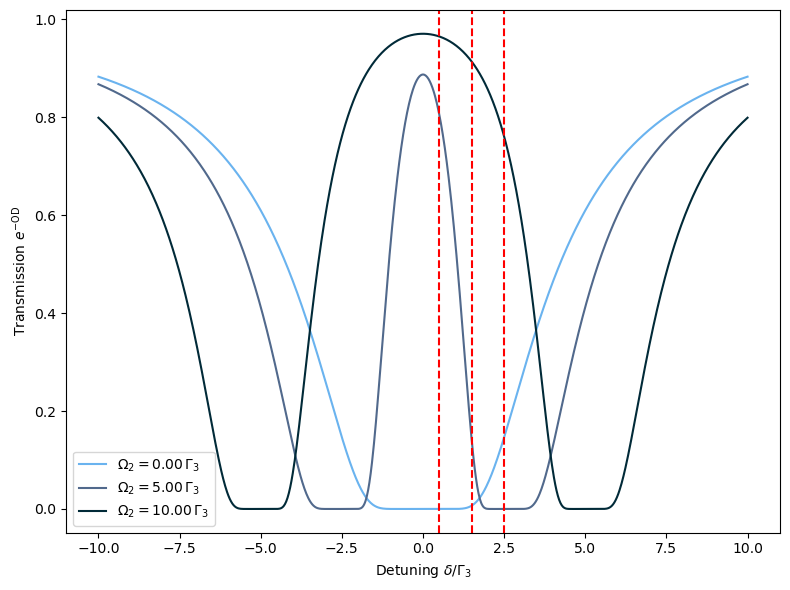

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# Assumes Gamma3, gamma13, N, mu_13, epsilon_0, hbar, k_1, L, mu_23, c are defined above
# and gamma12 = 0.03 * Gamma3
# =============================================================================

gamma12 = 0.03 * Gamma3

# =============================================================================
# Function to compute Transmission vs. probe detuning (for one dimensionless Omega_c)
# =============================================================================
def transmission_vs_detuning_dimless(
    Om_p_mhz=1.0,
    Om_c_dimless=1.0,
    delta_c_mhz=0.0,
    detuning_min=-50.0,
    detuning_max=50.0,
    num_points=1000
):
    Om_c_mhz = Om_c_dimless * Gamma3
    delta_p_list = np.linspace(detuning_min, detuning_max, num_points)
    T_list = []

    for dp in delta_p_list:
        numerator = 2 * Om_p_mhz * (dp - delta_c_mhz + 1j * gamma12)
        denominator = (
            Om_c_mhz * np.conjugate(Om_c_mhz)
            - 4 * (dp - delta_c_mhz + 1j * gamma12) * (dp + 1j * gamma13)
        )
        rho31 = numerator / denominator
        chi = (2 * N * rho31 * mu_13**2) / (epsilon_0 * hbar * (Om_p_mhz * 1e6))
        OD = k_1 * np.imag(chi) * L
        T_list.append(np.exp(-OD))

    return delta_p_list, np.array(T_list)

# =============================================================================
# Plot function to compare multiple dimensionless Omega_c values with a 
# partially-clamped (0.2 -> 0.8) gradient colormap, and save data to files
# =============================================================================
def plot_transmission_multi_OmC_dimless(
    Om_p_mhz,
    Om_c_values_dimless,
    delta_c_mhz,
    detuning_min=-50.0,
    detuning_max=50.0,
    num_points=1000
):
    # create output folder
    out_folder = r"C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2c"
    os.makedirs(out_folder, exist_ok=True)

    plt.figure(figsize=(8, 6))
    custom_colors = ["#6ab3ef", "#51698c", "#012a38"]  # bright, medium, dark

    for idx, Om_c_dimless in enumerate(Om_c_values_dimless):
        delta_p_list, T_list = transmission_vs_detuning_dimless(
            Om_p_mhz=Om_p_mhz,
            Om_c_dimless=Om_c_dimless,
            delta_c_mhz=delta_c_mhz,
            detuning_min=detuning_min,
            detuning_max=detuning_max,
            num_points=num_points
        )

        # save to text file
        fname = f"2c_OmC_{Om_c_dimless:.2f}.txt"
        path = os.path.join(out_folder, fname)
        header = (
            "# Transmission vs Detuning data\n"
            "# Columns: Detuning_MHz    Transmission\n"
            f"# Om_p={Om_p_mhz}MHz, Om_c/Gamma3={Om_c_dimless}, delta_c={delta_c_mhz}MHz, gamma12={gamma12}MHz\n"
        )
        data = np.column_stack((delta_p_list, T_list))
        np.savetxt(path, data, fmt="%.6e", header=header, comments='')
        print(f"Saved data to {path}")

        # plot curve
        label_str = fr"$\Omega_2={Om_c_dimless:.2f}\,\Gamma_3$"
        plt.plot(delta_p_list / Gamma3, T_list,
                 label=label_str,
                 color=custom_colors[idx % len(custom_colors)])

    # add vertical markers
    plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1.5)
    plt.axvline(x=1.5, color='red', linestyle='--', linewidth=1.5)
    plt.axvline(x=2.5, color='red', linestyle='--', linewidth=1.5)

    plt.xlabel(r"Detuning $\delta/\Gamma_3$")
    plt.ylabel(r"Transmission $e^{-\mathrm{OD}}$")
    plt.legend()
    plt.tight_layout()

    # save figure
    plt.savefig(r"C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2c\2c.svg", format="svg")
    plt.show()

# =============================================================================
# Example usage
# =============================================================================
if __name__ == "__main__":
    Om_p_example = 1.0
    delta_c_example = 0.0
    detuning_min = -10 * Gamma3
    detuning_max =  10 * Gamma3
    Om_c_values_dimless = [0.00, 5.00, 10.0]

    plot_transmission_multi_OmC_dimless(
        Om_p_mhz=Om_p_example,
        Om_c_values_dimless=Om_c_values_dimless,
        delta_c_mhz=delta_c_example,
        detuning_min=detuning_min,
        detuning_max=detuning_max,
        num_points=1000
    )


Saved data to C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2d\2d_delta1_18.85MHz.txt
Saved data to C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2d\2d_delta1_56.55MHz.txt
Saved data to C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2d\2d_delta1_94.25MHz.txt


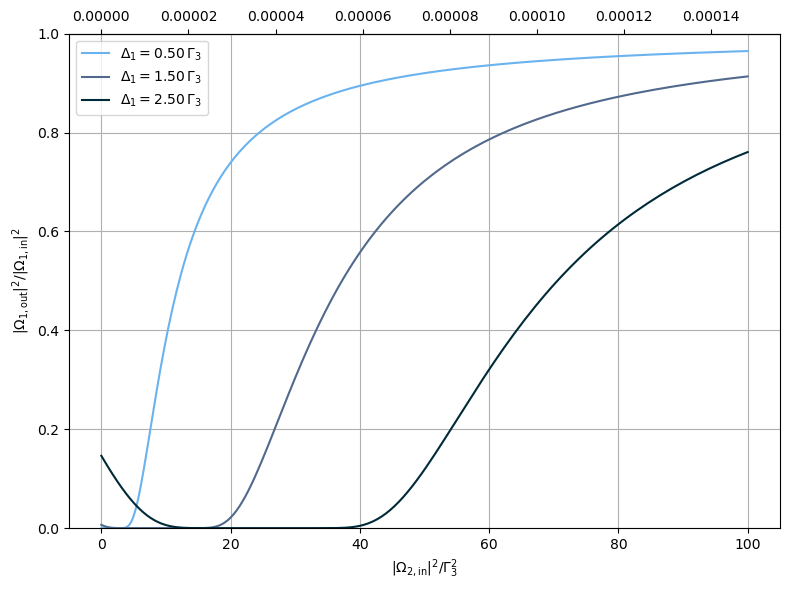

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul  8 20:36:04 2025

@author: none
"""

import os
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# Assumes Gamma3, gamma13, N, mu_13, epsilon_0, hbar, k_1, L, mu_23, c, K_2,
# x_forward, x_inverse, and gamma12 = 0.03 * Gamma3 are already defined above.
# =============================================================================

# =============================================================================
# Single-point function: returns Transmission for given (Om_p, Delta_1, Delta_2, Om_c)
# =============================================================================
def single_pass_transmission(Om_p_mhz, delta_1_mhz, delta_2_mhz, Om_c_mhz):
    numerator = 2 * Om_p_mhz * (delta_1_mhz - delta_2_mhz + 1j * gamma12)
    denominator = (
        Om_c_mhz * np.conjugate(Om_c_mhz)
        - 4 * (delta_1_mhz - delta_2_mhz + 1j * gamma12)
              * (delta_1_mhz + 1j * gamma13)
    )
    rho31 = numerator / denominator
    chi = (2 * N * rho31 * mu_13**2) / (epsilon_0 * hbar * (Om_p_mhz * 1e6))
    OD = k_1 * np.imag(chi) * L
    return np.exp(-OD)
w0 = 71e-6          # In m
# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
# =============================================================================
# Main function: For various Delta_1, we vary (Omega_c^2) and plot 
# =============================================================================
def plot_omega1out_sq_vs_omega2in_sq(
    Om_p_mhz       = 0.001,
    delta_1_list_mhz = [-2.0, 0.0, 2.0],
    delta_2_mhz    = 0.0,
    Om_c_dimless_min = 0.0,
    Om_c_dimless_max = 5.0,
    num_points     = 300
):
    # prepare output folder
    out_folder = r"C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2d"
    os.makedirs(out_folder, exist_ok=True)

    Om_c_dimless_array = np.linspace(Om_c_dimless_min, Om_c_dimless_max, num_points)
    x_values = Om_c_dimless_array**2  # dimensionless

    fig, ax1 = plt.subplots(figsize=(8,6))
    custom_colors = ["#6ab3ef", "#51698c", "#012a38"]

    for idx, delta_1_mhz in enumerate(delta_1_list_mhz):
        T_curve = [
            single_pass_transmission(
                Om_p_mhz, delta_1_mhz, delta_2_mhz, Om_c_dimless * Gamma3
            )
            for Om_c_dimless in Om_c_dimless_array
        ]
        T_curve = np.array(T_curve)

        # save data
        fname = f"2d_delta1_{delta_1_mhz:.2f}MHz.txt"
        path = os.path.join(out_folder, fname)
        header = (
            "# |Omega1_out|^2/|Omega1_in|^2 vs (Omega2_in/Gamma3)^2\n"
            "# Columns: OmC_dimless_sq    Transmission\n"
            f"# Params: Om_p={Om_p_mhz}MHz, delta_2={delta_2_mhz}MHz, delta_1={delta_1_mhz}MHz\n"
        )
        data = np.column_stack((x_values, T_curve))
        np.savetxt(path, data, fmt="%.6e", header=header, comments='')
        print(f"Saved data to {path}")

        # plot
        label = fr"$\Delta_1={delta_1_mhz/Gamma3:.2f}\,\Gamma_3$"
        plt.plot(x_values, T_curve,
                 label=label,
                 color=custom_colors[idx % len(custom_colors)])

    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    plt.grid()
    plt.ylim(0, 1)
    plt.margins(y=0.3)
    plt.xlabel(r"$|\Omega_{2,\mathrm{in}}|^2/\Gamma_3^2$")
    plt.ylabel(r"$|\Omega_{1,\mathrm{out}}|^2/|\Omega_{1,\mathrm{in}}|^2$")
    plt.legend()
    plt.tight_layout()

    # save figure
    plt.savefig(r"C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2d\2d.svg", format="svg")
    plt.show()

# =============================================================================
# Example usage
# =============================================================================
if __name__ == "__main__":
    # Example parameters
    Om_p_example = 0.001   # Probe Rabi freq (MHz)
    delta_2_example = 0.0  # Coupling detuning (MHz)

    # We'll see how the final probe amplitude depends on coupling power 
    # for three different probe detunings: 0.0, 1.0, 5.0 MHz
    delta_1_values = [0.5 * Gamma3, 1.5 * Gamma3, 2.5 * Gamma3] 

    plot_omega1out_sq_vs_omega2in_sq(
        Om_p_mhz         = Om_p_example,
        delta_1_list_mhz = delta_1_values,
        delta_2_mhz      = delta_2_example,
        Om_c_dimless_min = 0.0,
        Om_c_dimless_max = np.sqrt(100),
        num_points       = 200
    )

<>:78: SyntaxWarning: invalid escape sequence '\m'
<>:78: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ruben\AppData\Local\Temp\ipykernel_9476\584052049.py:78: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Transmission $e^{-\mathrm{OD}}$")


Saved data to C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2a\trans_gamma12_0.003770MHz.txt
Saved data to C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2a\trans_gamma12_3.769911MHz.txt
Saved data to C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2a\trans_gamma12_18.849556MHz.txt


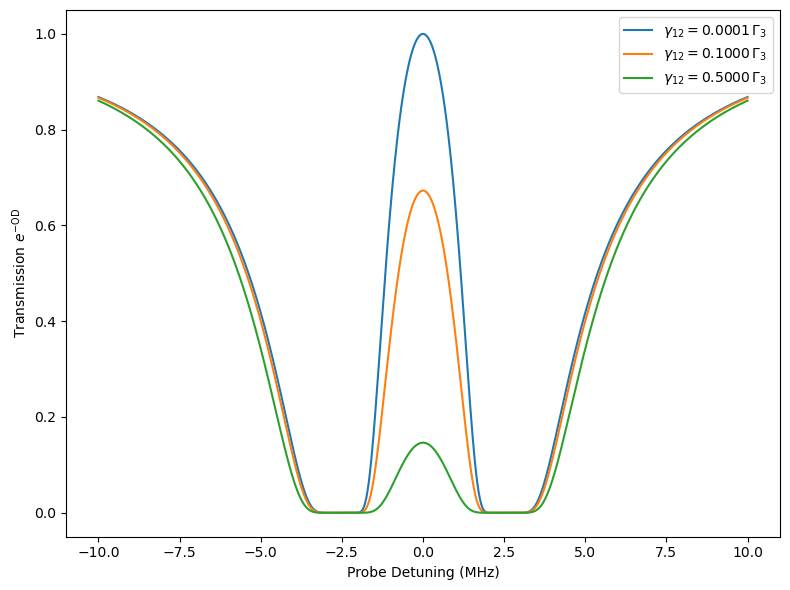

In [17]:
def transmission_vs_detuning_dimless_g12(
    Om_p_mhz=1.0,
    Om_c_dimless=1.0,
    gamma12_mhz=0.001,
    delta_c_mhz=0.0,
    detuning_min=-50.0,
    detuning_max=50.0,
    num_points=1000
):
    Om_c_mhz = Om_c_dimless * Gamma3
    delta_p_list = np.linspace(detuning_min, detuning_max, num_points)
    T_list = []
    for dp in delta_p_list:
        numerator = 2 * Om_p_mhz * (dp - delta_c_mhz + 1j * gamma12_mhz)
        denominator = (
            Om_c_mhz * np.conjugate(Om_c_mhz)
            - 4 * (dp - delta_c_mhz + 1j * gamma12_mhz) * (dp + 1j * gamma13)
        )
        rho31 = numerator / denominator
        chi = (2 * N * rho31 * mu_13**2) / (epsilon_0 * hbar * (Om_p_mhz * 1e6))
        OD = k_1 * np.imag(chi) * L
        T_list.append(np.exp(-OD))
    return delta_p_list, np.array(T_list)

#%%
# 2) Plot multiple gamma12 and save data

def plot_transmission_multi_gamma12(
    Om_p_mhz,
    Om_c_dimless,
    gamma12_values_mhz,
    delta_c_mhz=0.0,
    detuning_min=-50.0,
    detuning_max=50.0,
    num_points=1000,
    out_folder=r"C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2a"
):
    # Create output folder
    os.makedirs(out_folder, exist_ok=True)

    plt.figure(figsize=(8, 6))
    # Custom colormap
    import matplotlib.colors as mcolors
    my_cmap = mcolors.LinearSegmentedColormap.from_list(
        'custom_blue', ['#0432FF', '#A5BFFF'], N=len(gamma12_values_mhz)
    )

    for idx, gamma12_mhz in enumerate(gamma12_values_mhz):
        delta_p_list, T_list = transmission_vs_detuning_dimless_g12(
            Om_p_mhz=Om_p_mhz,
            Om_c_dimless=Om_c_dimless,
            gamma12_mhz=gamma12_mhz,
            delta_c_mhz=delta_c_mhz,
            detuning_min=detuning_min,
            detuning_max=detuning_max,
            num_points=num_points
        )
        # Save data
        filename = f"trans_gamma12_{gamma12_mhz:.6f}MHz.txt"
        path = os.path.join(out_folder, filename)
        header = (
            f"# Transmission vs Detuning data\n"
            f"# Om_p = {Om_p_mhz} MHz\n"
            f"# Om_c/Gamma3 = {Om_c_dimless}\n"
            f"# gamma12 = {gamma12_mhz} MHz\n"
            f"# delta_c = {delta_c_mhz} MHz\n"
            f"# Columns: Detuning_MHz  Transmission\n"
        )
        data = np.column_stack((delta_p_list, T_list))
        np.savetxt(path, data, fmt="%.6e", header=header)
        print(f"Saved data to {path}")

        # Plot
        x_vals = delta_p_list / Gamma3
        plt.plot(x_vals, T_list, label=fr"$\gamma_{{12}}={gamma12_mhz/Gamma3:.4f}\,\Gamma_3$")

    plt.xlabel("Probe Detuning (MHz)")
    plt.ylabel("Transmission $e^{-\mathrm{OD}}$")
    plt.legend()
    plt.tight_layout()
    plt.savefig(r"C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2a\2a.svg", format="svg")
    plt.show()

# =============================================================================
# Example usage
# =============================================================================
if __name__ == "__main__":
    # Example: fix dimensionless coupling at Om_c_dimless=1.0 => Om_c ~ 37.7 MHz
    Om_p_example    = 0.001    # Probe Rabi freq (MHz)
    Om_c_example    = 5.0      # dimensionless => actual ~ 37.7 MHz
    delta_c_example = 0.0      # Coupling detuning (MHz)
    detuning_min    = -10 * Gamma3
    detuning_max    = 10 * Gamma3

    # Sweep gamma12 from 0.001 MHz to 1.0 MHz in log steps, for example
    gamma12_vals = [0.0001 * Gamma3, 0.1 * Gamma3, 0.5 * Gamma3] 
    # [0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1.0] (adjust # of steps as you like)

    # Or just do a few discrete values:
    # gamma12_vals = [0.001, 0.01, 0.1, 0.5]

    # Plot
    plot_transmission_multi_gamma12(
        Om_p_mhz         = Om_p_example,
        Om_c_dimless     = Om_c_example,
        gamma12_values_mhz = gamma12_vals,
        delta_c_mhz      = delta_c_example,
        detuning_min     = detuning_min,
        detuning_max     = detuning_max,
        num_points       = 1000
    )

Saved data with power axis to C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2b\data_gamma12_0.003770MHz.txt
Saved data with power axis to C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2b\data_gamma12_3.769911MHz.txt
Saved data with power axis to C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2b\data_gamma12_18.849556MHz.txt


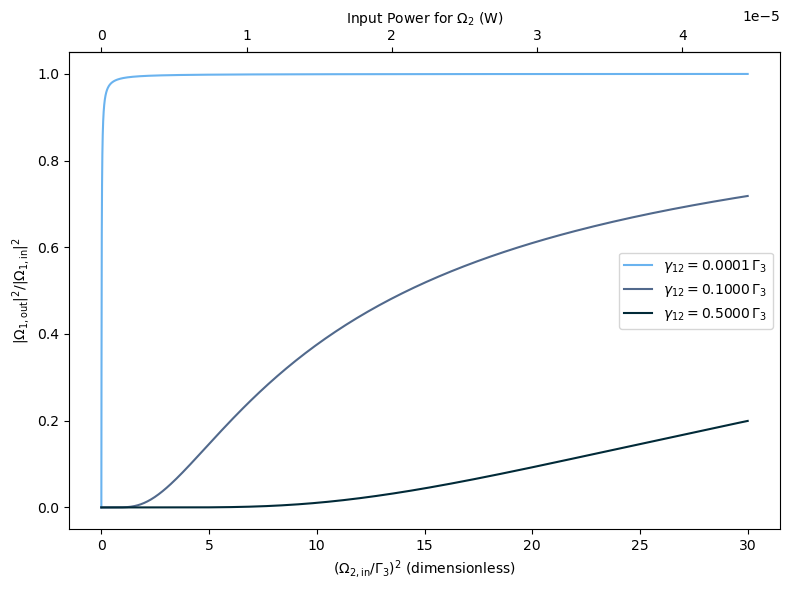

In [7]:

def single_pass_transmission_g12(
    Om_p_mhz, delta_1_mhz, delta_2_mhz, Om_c_mhz, gamma12_mhz
):
    """
    Computes exp(-OD) for a single pass with given parameters:
      Om_p_mhz    : probe Rabi frequency (MHz)
      delta_1_mhz : probe detuning (MHz)
      delta_2_mhz : coupling detuning (MHz)
      Om_c_mhz    : coupling Rabi frequency (MHz)
      gamma12_mhz : ground-state decoherence (MHz)
    """
    numerator = 2 * Om_p_mhz * (delta_1_mhz - delta_2_mhz + 1j * gamma12_mhz)
    denominator = (
        Om_c_mhz * np.conjugate(Om_c_mhz)
        - 4 * (delta_1_mhz - delta_2_mhz + 1j * gamma12_mhz)
              * (delta_1_mhz + 1j * gamma13)
    )
    rho31 = numerator / denominator
    chi   = (2 * N * rho31 * mu_13**2) / (epsilon_0 * hbar * (Om_p_mhz * 1e6))
    OD    = k_1 * np.imag(chi) * L
    return np.exp(-OD)

w0 = 71e-6          # In m
# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
#%%
def plot_omega1out_sq_vs_omega2in_sq_gamma12(
    Om_p_mhz,
    delta_1_mhz,
    delta_2_mhz,
    gamma12_vals_mhz,
    Om_c_dimless_min,
    Om_c_dimless_max,
    num_points=300,
    out_folder=r"C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2b"
):
    """
    Sweep Om_c_dimless from min to max and multiple gamma12 values,
    plot |Ω1_out|²/|Ω1_in|² vs (Ω2_in/Γ3)², and save three-column data:
      1) dimensionless (Ω2/Γ3)²
      2) corresponding laser power (W)
      3) transmission exp(-OD)
    """
    os.makedirs(out_folder, exist_ok=True)

    Om_c_dimless_array = np.linspace(Om_c_dimless_min, Om_c_dimless_max, num_points)
    x_dimless = Om_c_dimless_array**2           # (Ω2/Γ3)²
    x_power   = x_forward(x_dimless)            # power in W

    plt.figure(figsize=(8, 6))
    custom_colors = ["#6ab3ef", "#51698c", "#012a38", "#003366", "#6699CC"]

    for idx, g12_mhz in enumerate(gamma12_vals_mhz):
        T_curve = np.array([
            single_pass_transmission_g12(
                Om_p_mhz, delta_1_mhz, delta_2_mhz,
                Om_c_dimless * Gamma3, g12_mhz
            )
            for Om_c_dimless in Om_c_dimless_array
        ])

        # Save data to text file
        fname = f"data_gamma12_{g12_mhz:.6f}MHz.txt"
        fpath = os.path.join(out_folder, fname)
        header = (
            "# Single-pass transmission data\n"
            "# Columns:\n"
            "# 1) x_dimless = (Omega2_in/Gamma3)^2  (unitless)\n"
            "# 2) Power_W   = x_forward(x_dimless)  (W)\n"
            "# 3) Transmission = |Omega1_out|^2/|Omega1_in|^2\n"
            f"# Params: Om_p={Om_p_mhz}MHz, Δ1={delta_1_mhz}MHz, Δ2={delta_2_mhz}MHz, γ12={g12_mhz}MHz\n"
        )
        data = np.column_stack((x_dimless, x_power, T_curve))
        np.savetxt(
            fpath,
            data,
            fmt="%.6e",
            header=header,
            comments='',
            encoding='utf-8'
        )
        print(f"Saved data with power axis to {fpath}")

        # Plot curve
        color = custom_colors[idx % len(custom_colors)]
        label = fr"$\gamma_{{12}}={g12_mhz/Gamma3:.4f}\,\Gamma_3$"
        plt.plot(x_dimless, T_curve, color=color, label=label)

    # Axes labels and secondary axis
    plt.xlabel(r"$(\Omega_{2,\mathrm{in}}/\Gamma_3)^2$ (dimensionless)")
    plt.ylabel(r"$|\Omega_{1,\mathrm{out}}|^2/|\Omega_{1,\mathrm{in}}|^2$")
    ax = plt.gca()
    ax_top = ax.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel("Input Power for $\\Omega_2$ (W)")
    plt.legend()
    plt.tight_layout()

    # Save figure
    plt.savefig(r"C:\Users\ruben\Downloads\Paper Data\Paper Data\Figure 2\2b\2b.svg", format="svg")
    plt.show()

if __name__ == "__main__":
    Om_p_example      = 0.001
    delta_1_example   = 0.0
    delta_2_example   = 0.0
    gamma12_vals      = gamma12_vals = [0.0001 * Gamma3, 0.1 * Gamma3, 0.5 * Gamma3] 

    plot_omega1out_sq_vs_omega2in_sq_gamma12(
        Om_p_mhz         = Om_p_example,
        delta_1_mhz      = delta_1_example,
        delta_2_mhz      = delta_2_example,
        gamma12_vals_mhz = gamma12_vals,
        Om_c_dimless_min = 0.0,
        Om_c_dimless_max = np.sqrt(30),
        num_points       = 300
    )
